## Example Bi-Network using QAOA ##
<br>
First we have to create the problem Hamiltonian in the Ising model and add a mixer Hamiltonian for optimizing using QAOA. To generate the Hamiltonian, we use the QUBO method, used in various other combinatorial problems.

In [1]:
from pyqubo import Array,Constraint,Placeholder
from matplotlib import pyplot as plt
import networkx as nx

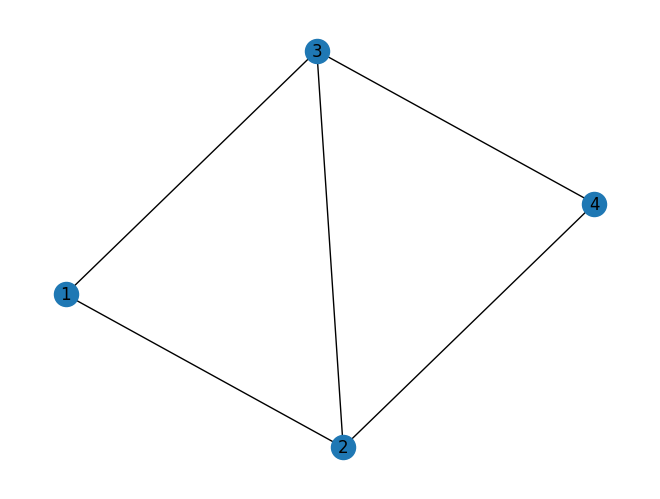

In [2]:
#edges = [(1,2),(2,1),(1,3),(3,1),(2,3),(3,2),(2,4),(4,2),(3,4),(4,3)]
#weights = [5,5,8,8,2,2,7,7,4,4]

edges = [(1,2),(1,3),(2,3),(2,4),(3,4)]
weights = [5,8,2,7,4]

x = Array.create(name = 'x', shape=len(edges), vartype = 'BINARY') #SPIN

G = nx.Graph(edges)
nx.draw(G, with_labels=True)

plt.show()

In [3]:
print(x.shape)
print(x)


(5,)
Array([Binary('x[0]'), Binary('x[1]'), Binary('x[2]'), Binary('x[3]'), Binary('x[4]')])


In [4]:
# model = ((x[0] + x[1] - 1)).compile()
# print(model.to_qubo())

In [5]:
i = 0
fcost = 0
for i in range(len(edges)):
    fcost += (weights[i]*x[i]) ## Put the expression for constraints in

p = 27 # chosen arbitrarily. It represents the penalty for the constraints. Also another parameter that can be varied


## Constraints-Graph Partitoning Problem ##
'''
# Constraint for source node (1):
fcost += p*((x[0] + x[2] - 1)**2) 
#Constraint for node (2):
fcost += p*((x[0] - x[1] - x[4] - x[6])**2)
# Constraint for node (3):
fcost += p*((x[2] - x[3] - x[5] - x[8])**2)
#Constraint for destination node (4):
fcost += p*((x[6] + x[8] - 1)**2)
fcost += p*((x[6] + x[7] + x[9] - 1)**2)
fcost += p*((x[8] + x[7] + x[9] - 1)**2)
fcost += p*((x[7] + x[9])**2)
'''

fcost += p*((x[0] + x[1] - 1)**2)

fcost += p*((x[0] - x[2] - x[3] + 1)**2)
fcost += p*((x[2] + x[3] - 1)**2)

fcost += p*((x[1] - x[2] - x[4] + 1)**2)
fcost += p*((x[2] + x[4] - 1)**2)

fcost += p*((x[4] + x[3] - 1)**2)

In [6]:
model = fcost.compile()

In [7]:
print(model.to_qubo())

({('x[4]', 'x[1]'): -54.0, ('x[0]', 'x[0]'): 59.0, ('x[2]', 'x[2]'): -106.0, ('x[4]', 'x[2]'): 108.0, ('x[3]', 'x[2]'): 108.0, ('x[3]', 'x[3]'): -74.0, ('x[1]', 'x[0]'): 54.0, ('x[2]', 'x[1]'): -54.0, ('x[4]', 'x[3]'): 54.0, ('x[3]', 'x[0]'): -54.0, ('x[2]', 'x[0]'): -54.0, ('x[4]', 'x[4]'): -77.0, ('x[1]', 'x[1]'): 62.0}, 162.0)


In [8]:
linear, quadratic, offset = model.to_ising()
print("Linear Coefficients", linear)
print("Quadratic Coefficients", quadratic)

## The objective function is then made from these linear and quadratic terms ##
## The objective function represents the Problem Hamiltonian Hp ##

Linear Coefficients {'x[0]': 16.0, 'x[1]': 17.5, 'x[2]': -26.0, 'x[3]': -10.0, 'x[4]': -11.5}
Quadratic Coefficients {('x[0]', 'x[1]'): 13.5, ('x[0]', 'x[2]'): -13.5, ('x[2]', 'x[3]'): 27.0, ('x[0]', 'x[3]'): -13.5, ('x[2]', 'x[4]'): 27.0, ('x[3]', 'x[4]'): 13.5, ('x[1]', 'x[2]'): -13.5, ('x[1]', 'x[4]'): -13.5}


In [9]:
#s = 'x['+str(0)+']'
#print(linear.get(s))

In [10]:
# print(int(list(quadratic.keys())[0][1][2]))

In [11]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

In [12]:
# AWS imports: Import Braket SDK modules
!pip install amazon-braket-sdk
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [13]:
def create_circuit(beta, gamma):
    ## initializing the initial qubit state with H gates ##
    circuit = Circuit()
    n_qubits = len(edges)

    for qubit in range(n_qubits):
        circuit.h(qubit)
    
    ## Implementing the problem Hamiltonian ##
    for qubit in range(n_qubits):
        linear_coeff = linear.get('x['+str(qubit)+']')
        circuit = circuit.rz(qubit, -1*linear_coeff)

    #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
    for i in range(len(quadratic)):
        qubit_1 = int(list(quadratic.keys())[i][0][2])
        qubit_2 = int(list(quadratic.keys())[i][1][2])

        quadratic_coeff = quadratic.get(('x['+str(qubit_1)+']', 'x['+str(qubit_2)+']'))
        
    # The Ising-Coupling Gate
        #circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)
        circuit.cnot(control=qubit_1, target=qubit_2)
        circuit.rz(qubit_2, quadratic_coeff*gamma)
        circuit.cnot(control=qubit_1, target=qubit_2)
    
    ## Implementing the Mixer Hamiltonian ##
    for qubit in range(n_qubits):
        circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle
    return circuit

* <b>Remember that there are 3 parameters that can be varied - beta, gamma and penalty p </b>

In [14]:
## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
## cost values over all states that have occurred ##
def compute_expectation(counts, shots):
    
    expectation = 0
    sum = 0
    states = list(counts.keys())
    for i in range(len(states)):
        state = states[i] # string variable of the current qubit states
        state_cost = 0
        for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
            state_cost = state_cost + int(state[j])*weights[j]
        
        expectation = expectation + state_cost*counts.get(state)
        
    expectation /= 10000
    # print(expectation)
    return expectation

In [15]:
## Now we measure the circuit ##
def expectation_execute_circuit(param):
    ## Set up the device to run the circuit
    device = LocalSimulator()
    
    ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
    beta = param[0]
    gamma = param[1]
    
    circuit = create_circuit(beta, gamma)
    
    shots = 10000
    result = device.run(circuit, shots).result()
    counts = result.measurement_counts
    
    return compute_expectation(counts, shots)    

In [16]:
## Classical Optimizer ##

from scipy.optimize import minimize

res = minimize(expectation_execute_circuit,
               [1.0, 1.0],
               method='SLSQP') # COBYLA
print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 14.7396
       x: [ 2.618e+05  1.778e+04]
     nit: 10
     jac: [ 2.913e+06  4.698e+05]
    nfev: 131
    njev: 10


## Analyzing the Results

In [17]:
beta = res.get('x')[0]
gamma = res.get('x')[1]
circuit = create_circuit(0.28517317, -5.05969577)

device = LocalSimulator()
result = device.run(circuit, shots = 10000).result()
counts = result.measurement_counts

print(counts)

len(counts.keys())
# plot using Counter
#plt.bar(counts.keys(), counts.values())
#plt.xlabel('bitstrings')
#plt.ylabel('counts')

Counter({'01101': 769, '10101': 730, '01010': 713, '00011': 713, '10110': 667, '00100': 565, '11000': 517, '10011': 441, '00000': 437, '00010': 406, '10100': 378, '10111': 350, '00101': 283, '11011': 260, '01111': 254, '10010': 253, '10001': 240, '01001': 234, '00001': 226, '11111': 200, '01100': 192, '11110': 177, '11100': 161, '11010': 159, '00110': 144, '11101': 127, '01000': 123, '01110': 97, '01011': 95, '10000': 48, '11001': 41})


31

In [18]:
#Carrying out annealing using dwave-neal

def anneal(model):
 import neal
 sampler = neal.SimulatedAnnealingSampler()
 bqm = model.to_bqm()
 sampleset = sampler.sample(bqm, num_reads=10)
 decoded_samples = model.decode_sampleset(sampleset)
 best_sample = min(decoded_samples, key=lambda x: x.energy)
 return best_sample.sample

res_neal = anneal(model)
print(res_neal)




{'x[0]': 0, 'x[1]': 1, 'x[2]': 1, 'x[3]': 0, 'x[4]': 1}


In [170]:
!pip install dwave-ocean-sdk --user --no-warn-script-location

In [ ]:
from dwave.cloud import Client
# Connect using the default or environment connection information
with Client.from_config() as client:

    # Load the default solver
    solver = client.get_solver()

    # Build a random Ising model to exactly fit the graph the solver supports
    linear, quadratic, offset = model.to_ising()

    # Send the problem for sampling, include solver-specific parameter 'num_reads'
    computation = solver.sample_ising(linear, quadtratic, num_reads=100)

    # Print the first sample out of a hundred
    print(computation.samples[0])